# Winter 2022 Data Science Intern Challenge

__Ian Sharff | ips11@georgetown.edu | 941-704-0087__

In [1]:
import os
import sys

# Data manipulation/analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Question 1: 
Given some sample data, write a program to answer the following: click <a href="https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0">here</a> to access the required data set.

On Shopify, we have exactly __100 sneaker shops__, and each of these shops sells only __one model of shoe__. We want to do some analysis of the ___average order value (AOV)___. When we look at orders data over a __30 day window__, we naively calculate an __AOV of $3145.13__. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

___

#### Data Analysis

In [2]:
# Read in CSV File, parsing dates as datetime objects for index
orders = pd.read_csv(
    'challenge_data.csv',
    index_col='created_at',
    parse_dates=True,
    infer_datetime_format=True
).sort_index()

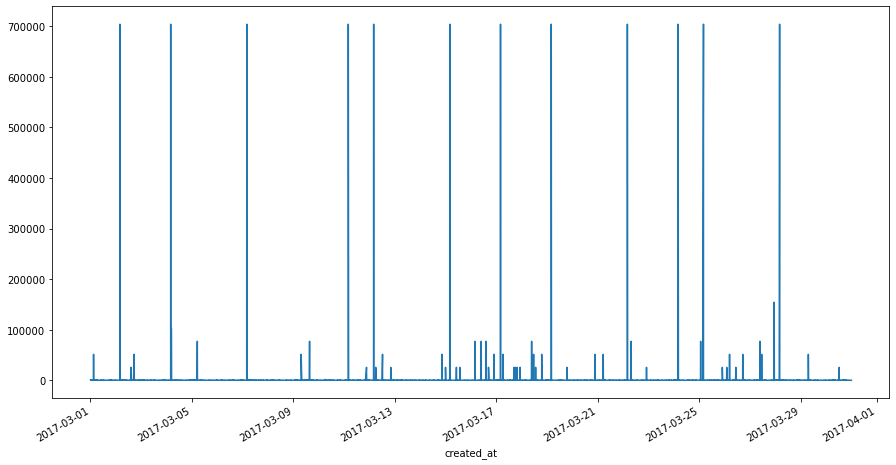

In [3]:
# Visualize all sales, order_amount vs created_at
orders.order_amount.plot(figsize=(15, 8));

Text(0, 0.5, 'Order Amount ($)')

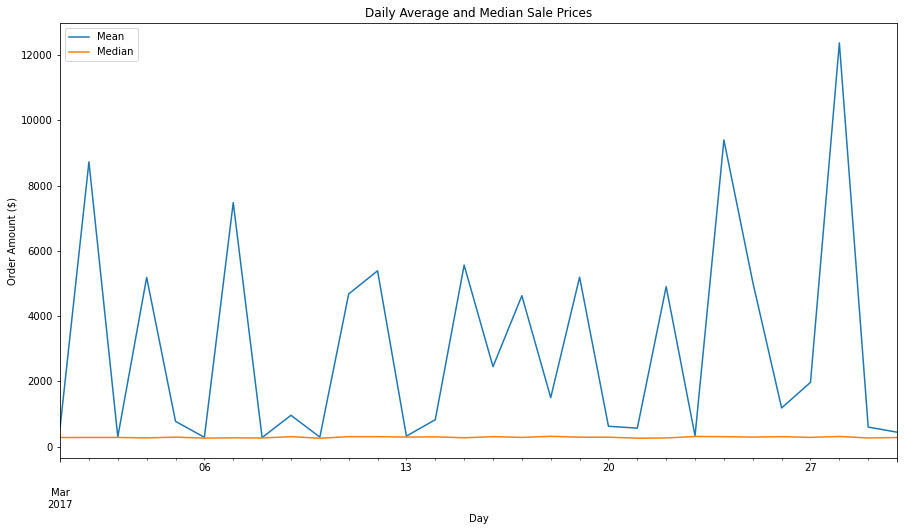

In [4]:
# Visualize daily average order amounts
orders.order_amount.resample('D').agg(['mean', 'median']).plot(figsize=(15, 8));
plt.title('Daily Average and Median Sale Prices')
plt.legend(['Mean', 'Median'])
plt.xlabel('Day')
plt.ylabel('Order Amount ($)')

In [5]:
# Get summary statistics from all orders
mean_order_amt = orders.order_amount.mean()
median_order_amt = orders.order_amount.median()
std_order_amt = orders.order_amount.std()

print(f"Mean:\t${mean_order_amt:,.2f}\nMedian:\t${median_order_amt:,.2f}\nStdev:\t${std_order_amt:,.2f}")

Mean:	$3,145.13
Median:	$284.00
Stdev:	$41,282.54


In [6]:
# Add column for unit prices, assuming only one type of shoe was sold
orders_calculated = orders.eval(
    """
    unit_price = order_amount / total_items
    """
)

In [7]:
# Find highest priced shop
orders_calculated.drop_duplicates(subset='shop_id').set_index('shop_id')['unit_price'].sort_values(ascending=False)

shop_id
78     25725.0
42       352.0
12       201.0
89       196.0
99       195.0
        ...   
7        112.0
100      111.0
32       101.0
2         94.0
92        90.0
Name: unit_price, Length: 100, dtype: float64

In [8]:
# Try removing outliers from the dataset by removing data points outside the 1.5 * IQR range
first_quartile = orders_calculated.unit_price.quantile(0.25)
third_quartile = orders_calculated.unit_price.quantile(0.75)
iqr = third_quartile - first_quartile
lower, upper = first_quartile - 1.5 * iqr, third_quartile + 1.5 * iqr

print(f"IQR: ${iqr}")
print(f"Non-outlier Range: ${lower} - ${upper}")

IQR: $36.0
Non-outlier Range: $79.0 - $223.0


In [9]:
mask = (orders_calculated['unit_price'] >= lower) & (orders_calculated['unit_price'] <= upper)
mask.value_counts()

True     4903
False      97
Name: unit_price, dtype: int64

In [10]:
orders_wo_outliers = orders_calculated[mask]

In [11]:
# Helper function to print summary statistics
def print_stats(df):
    summary_stats = df.describe()
    # Order amount statistics
    mu_oa, std_oa, med_oa = summary_stats.loc[['mean', 'std', '50%'], 'order_amount']
    # Unit price statistics
    unique_unit_prices = df.unit_price.unique()
    mu_up = np.mean(unique_unit_prices)
    med_up = np.median(unique_unit_prices)
    std_up = np.std(unique_unit_prices)
    
    print("\tMean order amount: ${:,.2f} ± {:,.2f}".format(mu_oa, std_oa))
    print("\tMedian order amount: ${:,.2f}".format(med_oa), '\n')
    print("\tMean unit price: ${:,.2f} ± {:,.2f}".format(mu_up, std_up))
    print("\tMedian unit price: ${:,.2f}".format(med_up))
    print()

In [12]:
print("WITH OUTLIERS")
print_stats(orders_calculated)
print("WITHOUT OUTLIERS")
print_stats(orders_wo_outliers)

WITH OUTLIERS
	Mean order amount: $3,145.13 ± 41,282.54
	Median order amount: $284.00 

	Mean unit price: $594.47 ± 3,328.83
	Median unit price: $153.50

WITHOUT OUTLIERS
	Mean order amount: $300.16 ± 155.94
	Median order amount: $284.00 

	Mean unit price: $150.04 ± 26.89
	Median unit price: $151.00



___

### Part A
___Think about what could be going wrong with our calculation. Think about a better way to evaluate this data___

The AOV value given above was calculated by simply taking the arithmetic mean across all orders in the period given between March and April 2017. However, with a mean order price of \\$3,145.13 and a standard deviation of \\$41,282.54, it is clear that the data is right-skewed due to the presence of outliers in the dataset. The highest amount paid in a single order during this period was \\$704,000, while the lowest was \\$90. 

Since each shop only sells a single type of shoe, the unit price can be calculated for each shop's product. This calculation was performed and the highest unit price, \\$25,725, was found was at shop number 78, and this is far from the mean (\\$387.74) and median (\\$151.00) values for unit price at all shops. As such, the simple arithmetic mean is likely an inadequate metric for this dataset when considered by itself.

A better way to evaluate this data might be to either 1) use the median as a preferred measure of central tendency or 2) remove outliers from the dataset. Shop number 78, while undoubtedly a major contributor to profit, is not reflective of the most commonly occuring order quantities and payment amounts for orders contained in this dataset.

___

### Part B
___What metric would you report for this dataset?___

As discussed earlier, the median would be a better measure of central tendency to consider due to the right skew in the data. However, the mean still carries significant information pertaining to sales; specifically, that shop number 78 yields considerably more revenue than other shops. However, exclusively considering the AOV value, i.e. the mean `order_amount`, as a summary statistic neglects important characteristics of the sales data.

___

### Part C:
___What is its value?___

The median `order_amount` in this dataset is __$284.00__, and the stability of this metric in spite of outliers is clear, given that after removing the 97 outliers (with respect to `unit_price`) the median remains the same. 

___

## Question 2:
For this question you’ll need to use SQL. Follow <a href="https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL">this link</a> to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

How many orders were shipped by Speedy Express in total?
What is the last name of the employee with the most orders?
What product was ordered the most by customers in Germany?

___

#### 1. How many orders were shipped by Speedy Express in total?

    SELECT Count(*)
    FROM Orders o
    WHERE o.ShipperID = (SELECT s.ShipperID
                         FROM Shippers s
                         WHERE s.ShipperName = "Speedy Express")
    
    ANSWER: 54

___

#### 2. What is the last name of the employee with the most orders?

    SELECT e.LastName 
    FROM   Employees e 
    WHERE  e.EmployeeID = (SELECT TOP 1 o.EmployeeID 
                           FROM   Orders o 
                           GROUP  BY o.EmployeeID
                           ORDER  BY Count(*) DESC);
    
    ANSWER: "Peacock"

___

#### 3. What product was ordered the most by customers in Germany?

    SELECT p.ProductName
    FROM Products p
    WHERE p.ProductID = 
    (
      SELECT TOP 1 od.ProductID
      FROM OrderDetails od
      WHERE od.OrderID IN
      (
        SELECT OrderID 
        FROM Orders o
        WHERE o.CustomerID IN
        (
          SELECT CustomerID FROM Customers
          WHERE Country = "Germany"
        )
      )
    );
    
    ANSWER: "Boston Crab Meat"